In [1]:
import numpy as np

class PriceModel():
    '''
    Note:This is a stateless class, gathering price evolution models in one place
    '''
    def price_model_1(current_price, current_action, tau, vol_matrix, perm_impact_matrix, random_vector):
        return current_price + np.sqrt(tau) * (vol_matrix@random_vector) - perm_impact_matrix @ current_action
    def price_model_2(current_price, current_action, tau, vol_matrix, perm_impact_matrix, random_vector):
        return current_price*np.exp(np.sqrt(tau) * (vol_matrix @ random_vector)) -\
                perm_impact_matrix @ current_action

In [2]:
import gym
from gym import spaces
import pandas as pd


class LiquidationEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, 
                 n_assets=1, 
                 initial_shares=250,
                 total_inventory = 300, 
                 initial_prices= 60, 
                 max_steps = 5,
                 price_model = PriceModel,
                 price_generator = PriceModel.price_model_1,
                 tau = 1,
                 temp_price_matrix = np.identity(1)*0.1,
                 vol_matrix = np.identity(1)*.4,
                 perm_impact_matrix = np.identity(1)*0.05,
                 # for capital ratio constraint
                 theta_min = 0.0625,
                 risk_weights = 8,
                 liability = 10000,
                 # lagrangian dual
                 lambda_value = 0.1                ):
        super(LiquidationEnv, self).__init__()
        
        # Environment parameters
        self.n_assets = n_assets
        self.initial_shares = np.full(n_assets, initial_shares, dtype=np.float32)
        self.total_inventory = np.full(n_assets, total_inventory, dtype=np.float32)
        self.initial_prices = np.full(n_assets, initial_prices, dtype=np.float32)
        self.max_steps = max_steps
        self.price_generator = price_generator
        self.temp_price_matrix = temp_price_matrix
        self.tau = tau
        self.vol_matrix = vol_matrix
        self.perm_impact_matrix = perm_impact_matrix
        # for capital ratio constriant

        self.theta_min = theta_min
        self.risk_weights = risk_weights
        self.liability = liability

        # dual variable
        self.lambda_value = lambda_value
        
        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=0,
            high= 1,
            shape=(n_assets,),
            dtype=np.float32
        )
        
        self.observation_space = spaces.Dict({
            "prices": spaces.Box(low = -np.inf, high=np.inf, shape=(n_assets,), dtype=np.float32),
            "remaining": spaces.Box(low = 0, high=1, shape=(n_assets,), dtype=np.float32),
            "acc_revenue": spaces.Box(low = -np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        })
        
        # Initialize state
        self.state = None
        self.current_step = 0
        self.reset()

    def _get_obs(self):
        return {
            "prices": self.state['prices'].copy().astype(np.float32)/self.initial_prices,
            "remaining": self.state['remaining'].copy().astype(np.float32)/self.initial_shares,
            "acc_revenue": np.array([self.state['acc_revenue']], dtype=np.float32)/(np.dot(self.initial_prices, self.initial_shares))
        }

    def _next_price(self, current_price , current_action, tau, vol_matrix, perm_impact_matrix, random_vector):
        # actual_action = self.state['remaining'] * current_action
        return self.price_generator(current_price, current_action, tau, vol_matrix, perm_impact_matrix, random_vector)

    def reset(self):
        # Reset initial prices (customize with your price initialization)
        self.state = {
            'prices': self.initial_prices.copy()/self.initial_prices,
            'remaining': self.initial_shares.copy()/self.initial_shares,
            'acc_revenue': 0.0
        }
        self.current_step = 0
        return self._get_obs()
    
    def _get_reward(self, state, action, temp_price_matrix):
        '''
        The function to calculate the reward
        '''
        # actual_action = action * state['remaining']
        reward = action.dot(state['prices']*self.initial_prices - temp_price_matrix.dot(action))/(np.dot(self.initial_prices, self.initial_shares))
        return reward
    
    def _check_safety_violation(self):
        # Calculate the revenue term.
        revenue_term = self.state['acc_revenue'] * np.dot(self.initial_prices, self.initial_shares)
        
        # Adjust inventory based on remaining shares and total inventory.
        adjusted_inventory = self.state['remaining'] * self.initial_shares + self.total_inventory - self.initial_shares
        # Construct the risk adjustment matrix.
        risk_adjustment = np.diag(np.ones(self.n_assets) - self.theta_min * self.risk_weights)
        # Calculate the price term.
        price_term = np.dot(self.state['prices'] * self.initial_prices,
                            risk_adjustment @ adjusted_inventory)
        
        # Compute the overall value.
        value = revenue_term + price_term - self.liability
        return value >= 0

    def step(self, action, scenario=None):
        if self.current_step < self.max_steps:
            # Take action normally until max_steps is reached
            if self.current_step == self.max_steps - 1:
                actual_action = self.state['remaining'] * self.initial_shares
            else:
                actual_action = np.minimum(self.state['remaining'] * self.initial_shares, action * self.initial_shares)

            reward = self._get_reward(self.state, actual_action, self.temp_price_matrix)

            # Check if the current state is safe.
            if self.current_step == 0:
                is_safe = True
            else:
                is_safe = self._check_safety_violation()  

            # Incorporate the Lagrangian multiplier as a bonus if safe.
            if self.current_step > 0:
                reward += self.lambda_value if is_safe else 0

            # Calculate revenue from current prices
            step_revenue = np.sum(actual_action * (self.state['prices'] * self.initial_prices - self.temp_price_matrix.dot(actual_action))) 
            self.state['acc_revenue'] = self.state['acc_revenue'] + step_revenue / (np.dot(self.initial_prices, self.initial_shares))
            self.state['remaining'] = (self.state['remaining'] * self.initial_shares - actual_action) / self.initial_shares
            
            # dynamics to next state
            if scenario == "upward":
                random_vector = np.full(self.n_assets,3) + np.abs(np.random.normal(size=self.n_assets))  # Force positive movement
            elif scenario == "stable":
                random_vector = np.zeros(self.n_assets)  # No movement
            elif scenario == "downward":
                random_vector = np.full(self.n_assets,-3) - np.abs(np.random.normal(size=self.n_assets))  # Force negative movement
            else:
                random_vector = np.random.normal(size=self.n_assets)  # Default behavior
            self.state['prices'] = self._next_price(self.state['prices'] * self.initial_prices, 
                                                    actual_action, self.tau, 
                                                    self.vol_matrix, self.perm_impact_matrix, 
                                                    random_vector) / self.initial_prices
            
            # Move to next step
            self.current_step += 1

            done = False  # Still taking actions until max_steps is reached

        else:
            reward = 0  # No reward since no action is taken
            is_safe = self._check_safety_violation()
            #print(f"Final step check (step {self.current_step}): is_safe={is_safe}")
            done = True  # Terminate after step 5
        #print(is_safe)
        return self._get_obs(), reward, done, {'is_safe': is_safe}


    def render(self, mode='human'):
        print(f"Step: {self.current_step}")
        print(f"Prices: {self.state['prices']}")
        print(f"Remaining: {self.state['remaining']}")
        print(f"Accumulated Revenue: {self.state['acc_revenue']:.2f}\n")

        
    def close(self):
        pass

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
env = LiquidationEnv(n_assets=1, initial_shares=250, price_generator = PriceModel.price_model_2, liability= 10000)
check_env(env)


/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:361: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [4]:
env.reset()
env.render()

Step: 0
Prices: [1.]
Remaining: [1.]
Accumulated Revenue: 0.00



In [8]:
action = np.ones(1)*0.2

env.step(action)

env.render()

Step: 4
Prices: [1.97796619]
Remaining: [0.2]
Accumulated Revenue: 0.85



np.float64(-5.0106352940962555)

In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback


env = LiquidationEnv(n_assets=1, initial_shares = 250, price_generator = PriceModel.price_model_2,vol_matrix= 0.02*np.identity(1))
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, price_generator = PriceModel.price_model_2,vol_matrix= 0.02*np.identity(1))
eval_callback = EvalCallback(env_eval, 
                            best_model_save_path=f"../log/model/gbm_test/",
                            eval_freq=100,
                            deterministic=True, 
                            render=False,
                            verbose=0)
model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log="../log/tensorboard_gbm_test/", verbose=0)
model.learn(int(10e5), progress_bar=True, callback=eval_callback)

Output()

/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

In [9]:
import numpy as np

def evaluate_policy(model, env, num_episodes=1000):
    """
    Evaluates the policy using `env._get_reward` instead of the step function's reward.
    
    Parameters:
        model: The trained RL model.
        env: The evaluation environment.
        num_episodes: Number of episodes to run.
    
    Returns:
        safety_ratio: Fraction of episodes that were entirely safe.
        avg_reward: Average episode reward computed using `env._get_reward`.
    """
    safe_episodes = 0
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        is_episode_safe = True  # Assume safe until proven otherwise

        while not done:
            action, _ = model.predict(obs, deterministic=True)  # Use policy to get action
            
            # Get reward using `_get_reward` instead of the reward from `env.step`
            actual_action = np.minimum(env.state['remaining'] * env.initial_shares, action * env.initial_shares)
            reward = env._get_reward(env.state, actual_action, env.temp_price_matrix)
            
            # Execute action in the environment
            obs, _, done, info = env.step(action)  # Ignore the default reward
            
            episode_reward += reward  # Accumulate manually computed reward

            # Check if the episode remains safe
            if 'is_safe' in info:
                if not info['is_safe']:
                    is_episode_safe = False  # If any step is unsafe, mark episode unsafe

        # Track safety only if the entire episode was safe
        if is_episode_safe:
            safe_episodes += 1
        total_rewards.append(episode_reward)

    # Calculate metrics
    safety_ratio = safe_episodes / num_episodes
    avg_reward = np.mean(total_rewards)

    return safety_ratio, avg_reward


In [5]:
from stable_baselines3 import PPO

# Load the best model from EvalCallback's auto-saved checkpoints
best_model = PPO.load("../log/model/gbm_test/best_model.zip")

In [9]:
ratio, reward = evaluate_policy(best_model, env, num_episodes=1000)

In [10]:
reward*250*60

np.float64(12243.15723989768)

In [11]:
ratio

0.422

### updating dual

In [18]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

# Hyperparameters
num_iterations = 10  # Number of iterations to update lambda
eta_lambda = 0.01  # Step size for dual variable update
delta = 0.2  # Safety threshold
lambda_value =  0.1 # Initial lambda value
tolerance = 0.8  # Convergence criteria for lambda

# Initialize environment and model
env = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value,theta_min= 0.062, liability= 10200)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, theta_min= 0.062,liability= 10200)
eval_callback = EvalCallback(env_eval, 
                             best_model_save_path="../log/model/test/",
                             eval_freq=100,
                             deterministic=True, 
                             render=False,
                             verbose=0)

# Iterate over lambda updates
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}: Training RL model with λ = {lambda_value:.4f}")

    # Train PPO with current lambda
    model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log="../log/tensorboard_test/", verbose=0)
    model.learn(int(8e5), progress_bar=True, callback=eval_callback)

    # Evaluate safety
    best_model = PPO.load("../log/model/test/best_model.zip")
    safety_ratio, avg_reward = evaluate_policy(best_model, env_eval, num_episodes=1000)
    print(f"Safety ratio: {safety_ratio:.4f}, Avg Reward: {avg_reward:.4f}")

    # Update lambda using dual gradient update
    new_lambda = max(lambda_value - eta_lambda * (safety_ratio - (1 - delta)), 0)

    print(f"Updated λ: {new_lambda:.4f}")

    # Convergence check
    if safety_ratio > 1- delta:
        print("Satisfying constraint; Stopping updates.")
        break
    
    lambda_value = new_lambda  # Update lambda for next iteration

    # Update environments with new lambda
    env.lambda_value = lambda_value
    env_eval.lambda_value = lambda_value


Output()

Iteration 1: Training RL model with λ = 0.1000


Safety ratio: 0.9770, Avg Reward: 0.7717
Updated λ: 0.0982
Satisfying constraint; Stopping updates.


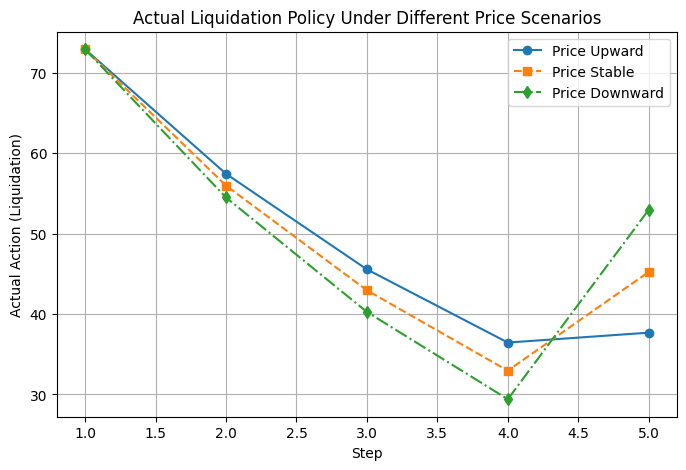

In [19]:
liability_value = 10200

# Load the trained model
best_model = PPO.load("../log/model/test/best_model.zip")

# Evaluate the actual actions under different price trends
avg_actual_actions_up = evaluate_policy_under_scenario(best_model, env_eval,5,scenario="upward")
avg_actual_actions_stable = evaluate_policy_under_scenario(best_model, env_eval,5, scenario="stable")
avg_actual_actions_down = evaluate_policy_under_scenario(best_model, env_eval, 5,scenario="downward")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1,6), avg_actual_actions_up, marker="o", linestyle="-", label="Price Upward")
plt.plot(range(1,6), avg_actual_actions_stable, marker="s", linestyle="--", label="Price Stable")
plt.plot(range(1,6), avg_actual_actions_down, marker="d", linestyle="-.", label="Price Downward")

plt.xlabel("Step")
plt.ylabel("Actual Action (Liquidation)")
plt.title("Actual Liquidation Policy Under Different Price Scenarios")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Hyperparameters
num_iterations = 10  # Number of iterations to update lambda
eta_lambda = 0.01  # Step size for dual variable update
delta = 0.2  # Safety threshold
lambda_value =  0.1 # Initial lambda value
tolerance = 0.8  # Convergence criteria for lambda
env = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, liability= 10000)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, liability= 10000)
eval_callback = EvalCallback(env_eval, 
                             best_model_save_path="../log/model/test/",
                             eval_freq=100,
                             deterministic=True, 
                             render=False,
                             verbose=0)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_average_policy(model, env, num_trajectories=1000):
    """
    Evaluates the trained policy over multiple trajectories and computes 
    the average action taken at each step.
    
    Parameters:
        model: Trained RL policy (PPO model).
        env: Environment for evaluation.
        num_trajectories: Number of trajectories to sample.
    
    Returns:
        avg_actions: Average action per step across all trajectories.
    """
    num_steps = 5  # We consider 5 steps (0,1,2,3 for actions, 4 for adjusted action)
    actions_all = np.zeros((num_trajectories, num_steps))  # Store actions for averaging

    for traj in range(num_trajectories):
        obs = env.reset()
        done = False
        step_count = 0
        actions_taken = []

        while not done and step_count < 5:  # Limit to 5 steps
            action, _ = model.predict(obs, deterministic=True)

            # Ensure action is scalar
            if isinstance(action, (np.ndarray, list)):
                action = action.item()

            obs, reward, done, info = env.step(action)

            if step_count < 4:
                actions_taken.append(action)
            elif step_count == 4:
                # Compute final interpreted action
                correct_action_4 = 1 - np.sum(actions_taken)
                correct_action_4 = np.clip(correct_action_4, 0, 1)
                actions_taken.append(correct_action_4)

            step_count += 1

        # Store trajectory actions (truncate in case of early termination)
        actions_all[traj, :len(actions_taken)] = actions_taken

    # Compute the average action for each step
    avg_actions = np.mean(actions_all, axis=0)
    
    return avg_actions



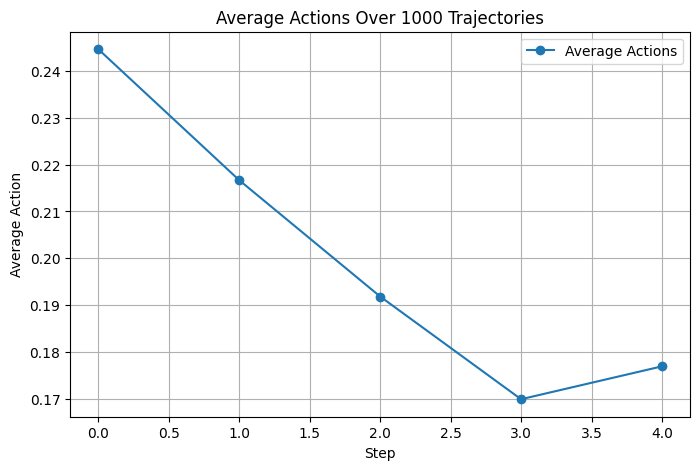

In [18]:
# Load the trained model
best_model = PPO.load("../log/model/test/best_model.zip")

# Evaluate the policy over 1000 trajectories
avg_actions = evaluate_average_policy(best_model, env_eval, num_trajectories=1000)

# Plot the average actions over steps
plt.figure(figsize=(8, 5))
plt.plot(range(len(avg_actions)), avg_actions, marker="o", linestyle="-", label="Average Actions")
plt.xlabel("Step")
plt.ylabel("Average Action")
plt.title("Average Actions Over 1000 Trajectories")
plt.legend()
plt.grid()
plt.show()


In [33]:
import os
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

# Hyperparameters
num_iterations = 10  # Number of iterations to update lambda
eta_lambda = 0.01  # Step size for dual variable update
delta = 0.2  # Safety threshold
lambda_value = 0.1  # Initial lambda value
tolerance = 0.8  # Convergence criteria for lambda
liability_value = 10500  # New liability value

# Define save paths dynamically based on liability value
model_save_path = f"../log/model/liability_{liability_value}/"
tensorboard_log_path = f"../log/tensorboard_liability_{liability_value}/"

# Ensure directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tensorboard_log_path, exist_ok=True)

# Initialize environment with the updated liability value
env = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, liability=liability_value)

eval_callback = EvalCallback(env_eval, 
                             best_model_save_path=model_save_path,
                             eval_freq=100,
                             deterministic=True, 
                             render=False,
                             verbose=0)

# Iterate over lambda updates
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}: Training RL model with λ = {lambda_value:.4f}")

    # Train PPO with current lambda
    model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log=tensorboard_log_path, verbose=0)
    model.learn(int(8e5), progress_bar=True, callback=eval_callback)

    # Evaluate safety
    best_model = PPO.load(os.path.join(model_save_path, "best_model.zip"))
    safety_ratio, avg_reward = evaluate_policy(best_model, env_eval, num_episodes=1000)
    print(f"Safety ratio: {safety_ratio:.4f}, Avg Reward: {avg_reward:.4f}")

    # Update lambda using dual gradient update
    new_lambda = max(lambda_value - eta_lambda * (safety_ratio - (1 - delta)), 0)
    print(f"Updated λ: {new_lambda:.4f}")

    # Convergence check
    if safety_ratio > 1 - delta:
        print("Satisfying constraint; Stopping updates.")
        break
    
    lambda_value = new_lambda  # Update lambda for next iteration

    # Update environments with new lambda
    env.lambda_value = lambda_value
    env_eval.lambda_value = lambda_value


Output()

Iteration 1: Training RL model with λ = 0.1000


Safety ratio: 0.9300, Avg Reward: 1.1786
Updated λ: 0.0987
Satisfying constraint; Stopping updates.


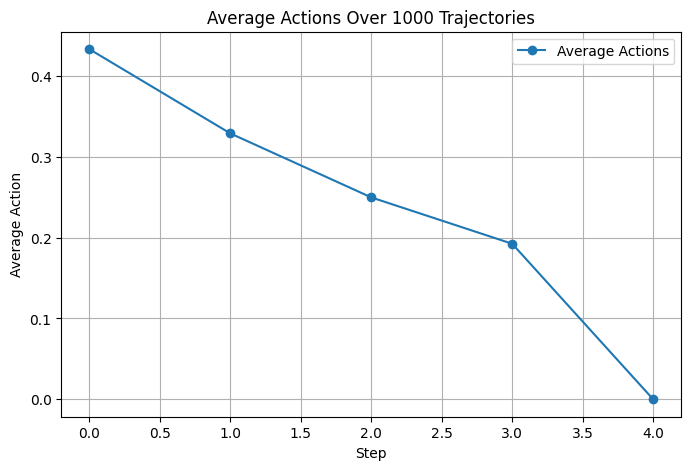

In [35]:
# Load the trained model
best_model = PPO.load("../log/model/liability_10500/best_model.zip")

# Evaluate the policy over 1000 trajectories
avg_actions = evaluate_average_policy(best_model, env_eval, num_trajectories=1000)

# Plot the average actions over steps
plt.figure(figsize=(8, 5))
plt.plot(range(len(avg_actions)), avg_actions, marker="o", linestyle="-", label="Average Actions")
plt.xlabel("Step")
plt.ylabel("Average Action")
plt.title("Average Actions Over 1000 Trajectories")
plt.legend()
plt.grid()
plt.show()


#### evaluate different scenarios

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

def evaluate_policy_under_scenario(model, env, num_episodes=100, scenario="upward"):
    """
    Evaluates a trained policy under a given price movement scenario and records the actual actions.

    Parameters:
        model: The trained RL policy.
        env: The environment with modified price behavior.
        num_episodes: Number of test episodes.
        scenario: "upward", "stable", or "downward".
    
    Returns:
        avg_actual_actions: Average `actual_action` per step across episodes.
    """
    num_steps = 5  # Considering steps 0-4
    actual_actions_all = np.zeros((num_episodes, num_steps))  # Store actual actions

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        step_count = 0
        actual_actions_taken = []

        while not done and step_count < 5:
            action, _ = model.predict(obs, deterministic=True)  # Policy action
            
            # Compute actual action, ensuring it is a scalar
            actual_action = np.minimum(env.state['remaining'] * env.initial_shares, action * env.initial_shares)
            if isinstance(actual_action, (np.ndarray, list)):
                actual_action = actual_action.item()  # Convert single-value array to scalar

            obs, _, done, _ = env.step(action, scenario=scenario)  # Pass scenario

            if step_count < 4:
                actual_actions_taken.append(actual_action)
            elif step_count == 4:
                # Compute step 4 action as `remaining` shares to ensure full liquidation
                actual_action = max(0, env.state['remaining'] * env.initial_shares)
                actual_actions_taken.append(actual_action)

            step_count += 1

        # Store the actual trajectory actions as a NumPy array
        actual_actions_all[episode, :len(actual_actions_taken)] = np.array(actual_actions_taken, dtype=float)

    # Compute average actual actions per step
    avg_actual_actions = np.mean(actual_actions_all, axis=0)
    
    return avg_actual_actions


In [13]:
import numpy as np

def evaluate_policy_under_scenario(model, env, num_steps, num_episodes=100, scenario="upward"):
    """
    Evaluates a trained policy under a given price movement scenario and records the actual actions.
    """
    actual_actions_all = np.zeros((num_episodes, num_steps))

    for episode in range(num_episodes):
        obs = env.reset()
        actual_actions_taken = []

        # Fixed: Use for loop to guarantee 5 steps
        for step_idx in range(num_steps):
            action, _ = model.predict(obs, deterministic=True)
            
            # Compute actual action
            if step_idx < num_steps - 1:
                actual_action = np.minimum(env.state['remaining'] * env.initial_shares,
                                         action * env.initial_shares)
            else:  # Step 4: Force liquidation of remaining shares
                actual_action = max(0, env.state['remaining'] * env.initial_shares)

            # Convert to scalar if needed
            if isinstance(actual_action, (np.ndarray, list)):
                actual_action = actual_action.item()

            # Store before stepping
            actual_actions_taken.append(actual_action)

            # Environment step
            obs, _, done, _ = env.step(action, scenario=scenario)

        # Store all 5 steps
        actual_actions_all[episode] = np.array(actual_actions_taken, dtype=float)

    # Return averages for all 5 steps
    return np.mean(actual_actions_all, axis=0)

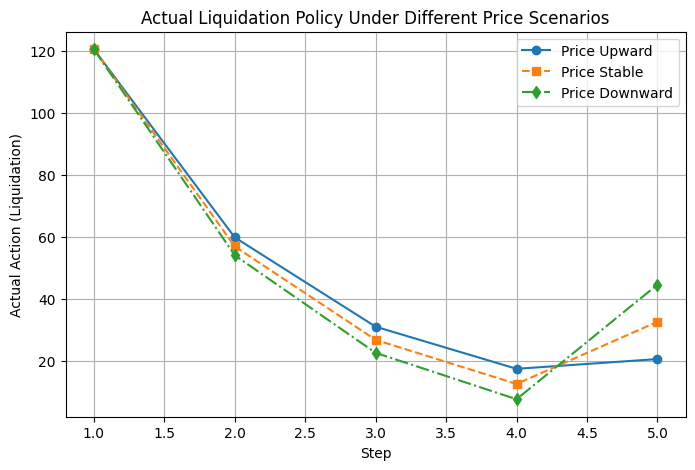

In [23]:
liability_value = 10600
env = LiquidationEnv(n_assets=1, initial_shares=250, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250,  liability=liability_value)
# Load the trained model
best_model = PPO.load("../log/model/liability_10600/best_model.zip")

# Evaluate the actual actions under different price trends
avg_actual_actions_up = evaluate_policy_under_scenario(best_model, env_eval, scenario="upward")
avg_actual_actions_stable = evaluate_policy_under_scenario(best_model, env_eval, scenario="stable")
avg_actual_actions_down = evaluate_policy_under_scenario(best_model, env_eval, scenario="downward")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1,6), avg_actual_actions_up, marker="o", linestyle="-", label="Price Upward")
plt.plot(range(1,6), avg_actual_actions_stable, marker="s", linestyle="--", label="Price Stable")
plt.plot(range(1,6), avg_actual_actions_down, marker="d", linestyle="-.", label="Price Downward")

plt.xlabel("Step")
plt.ylabel("Actual Action (Liquidation)")
plt.title("Actual Liquidation Policy Under Different Price Scenarios")
plt.legend()
plt.grid()
plt.show()

In [24]:
liability_value = 10600
env = LiquidationEnv(n_assets=1, initial_shares=250, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250,  liability=liability_value)
# Load the trained model
best_model = PPO.load("../log/model/liability_10600/best_model.zip")
ratio, reward = evaluate_policy(best_model, env,10000)
ratio

0.7258

In [9]:
avg_actual_actions_up

array([120.59341431,  59.83202366,  31.09959789,  17.55956991,
         0.        ])

In [38]:
avg_actual_actions_stable

array([120.59341431,  57.01980591,  26.9210453 ,  12.7072134 ,
        32.75852203])

In [39]:
avg_actual_actions_down

array([120.59341431,  54.17397305,  22.73515953,   7.82658113,
        44.6708717 ])

array([0.43306175, 0.32897612, 0.24978159, 0.19244951, 0.        ])

In [7]:
import os
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

# Hyperparameters
num_iterations = 10  # Number of iterations to update lambda
eta_lambda = 0.01  # Step size for dual variable update
delta = 0.2  # Safety threshold
lambda_value = 0.1  # Initial lambda value
liability_value = 10600  # New liability value

# Define save paths dynamically based on liability value
model_save_path = f"../log/model/liability_{liability_value}/"
tensorboard_log_path = f"../log/tensorboard_liability_{liability_value}/"

# Ensure directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tensorboard_log_path, exist_ok=True)

# Initialize environment with the updated liability value
env = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, lambda_value=lambda_value, liability=liability_value)

eval_callback = EvalCallback(env_eval, 
                             best_model_save_path=model_save_path,
                             eval_freq=100,
                             deterministic=True, 
                             render=False,
                             verbose=0)

# Iterate over lambda updates
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}: Training RL model with λ = {lambda_value:.4f}")

    # Train PPO with current lambda
    model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log=tensorboard_log_path, verbose=0)
    model.learn(int(8e5), progress_bar=True, callback=eval_callback)

    # Evaluate safety
    best_model = PPO.load(os.path.join(model_save_path, "best_model.zip"))
    safety_ratio, avg_reward = evaluate_policy(best_model, env_eval, num_episodes=1000)
    print(f"Safety ratio: {safety_ratio:.4f}, Avg Reward: {avg_reward:.4f}")

    # Update lambda using dual gradient update
    new_lambda = max(lambda_value - eta_lambda * (safety_ratio - (1 - delta)), 0)
    print(f"Updated λ: {new_lambda:.4f}")

    # Convergence check
    if safety_ratio > 1 - delta:
        print("Satisfying constraint; Stopping updates.")
        break
    
    lambda_value = new_lambda  # Update lambda for next iteration

    # Update environments with new lambda
    env.lambda_value = lambda_value
    env_eval.lambda_value = lambda_value


Iteration 1: Training RL model with λ = 0.1000


Output()

/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Output()

Safety ratio: 0.5750, Avg Reward: 0.0074
Updated λ: 0.1023
Iteration 2: Training RL model with λ = 0.1023


Output()

Safety ratio: 0.5740, Avg Reward: 0.0074
Updated λ: 0.1045
Iteration 3: Training RL model with λ = 0.1045


Output()

Safety ratio: 0.7360, Avg Reward: 0.0033
Updated λ: 0.1052
Iteration 4: Training RL model with λ = 0.1052


Output()

Safety ratio: 0.7240, Avg Reward: 0.0033
Updated λ: 0.1059
Iteration 5: Training RL model with λ = 0.1059


Output()

Safety ratio: 0.7600, Avg Reward: 0.0033
Updated λ: 0.1063
Iteration 6: Training RL model with λ = 0.1063


Output()

Safety ratio: 0.7620, Avg Reward: 0.0034
Updated λ: 0.1067
Iteration 7: Training RL model with λ = 0.1067


Output()

Safety ratio: 0.7260, Avg Reward: 0.0034
Updated λ: 0.1074
Iteration 8: Training RL model with λ = 0.1074


Output()

Safety ratio: 0.7310, Avg Reward: 0.0034
Updated λ: 0.1081
Iteration 9: Training RL model with λ = 0.1081


Output()

Safety ratio: 0.7390, Avg Reward: 0.0034
Updated λ: 0.1087
Iteration 10: Training RL model with λ = 0.1087


Safety ratio: 0.7490, Avg Reward: 0.0034
Updated λ: 0.1092


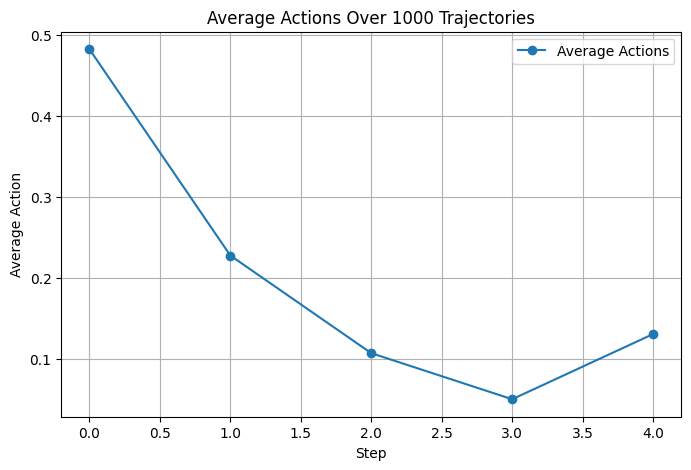

In [10]:
# Load the trained model
best_model = PPO.load("../log/model/liability_10600/best_model.zip")

# Evaluate the policy over 1000 trajectories
avg_actions = evaluate_average_policy(best_model, env_eval, num_trajectories=1000)

# Plot the average actions over steps
plt.figure(figsize=(8, 5))
plt.plot(range(len(avg_actions)), avg_actions, marker="o", linestyle="-", label="Average Actions")
plt.xlabel("Step")
plt.ylabel("Average Action")
plt.title("Average Actions Over 1000 Trajectories")
plt.legend()
plt.grid()
plt.show()


In [16]:
evaluate_policy(best_model, env, num_episodes=1000)[1]*250*60

np.float64(10749.447753031609)

#### evaluate fixed policy

In [17]:
import numpy as np
env_test = LiquidationEnv(n_assets=1, initial_shares = 250)

def evaluate_fixed_policy(env, num_episodes=1000, policy_actions=None):
    """
    Evaluates a fixed policy in the given environment and computes the safety ratio.

    Parameters:
        env: The evaluation environment.
        num_episodes: Number of episodes to run.
        policy_actions: A list of actions for steps 0, 1, 2, 3. 
                        The step 4 action will be computed as `1 - sum(policy_actions)`.
    
    Returns:
        safety_ratio: Fraction of episodes that were entirely safe.
        avg_reward: Average episode reward.
    """
    if policy_actions is None or len(policy_actions) != 4:
        raise ValueError("policy_actions must be a list of 4 predefined actions for steps 0, 1, 2, and 3.")

    safe_episodes = 0
    total_rewards = []

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        is_episode_safe = True  # Assume safe until proven otherwise
        step_count = 0
        actions_taken = []

        while not done and step_count < 5:  # Limit to 5 steps
            if step_count < 4:
                action = policy_actions[step_count]  # Use predefined action
            elif step_count == 4:
                # Compute step 4 action as `1 - sum(actions_taken)`
                action = max(0, 1 - np.sum(actions_taken))
            
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            actions_taken.append(action)

            # Check safety status
            if 'is_safe' in info:
                if not info['is_safe']:
                    is_episode_safe = False  # Mark episode as unsafe if any step is unsafe

            step_count += 1

        # Track safety only if the entire episode was safe
        if is_episode_safe:
            safe_episodes += 1
        total_rewards.append(episode_reward)

    # Calculate metrics
    safety_ratio = safe_episodes / num_episodes
    avg_reward = np.mean(total_rewards)

    return safety_ratio, avg_reward


In [47]:
# Define an evenly spread policy (first 4 steps)
even_spread_policy = [0.2, 0.2, 0.2, 0.2]  # Step 4 will be `1 - sum(policy_actions)`

# Run evaluation
safety_ratio, avg_reward = evaluate_fixed_policy(env_test, num_episodes=1000, policy_actions=even_spread_policy)
print(f"Evenly Spread Policy -> Safety Ratio: {safety_ratio:.4f}, Avg Reward: {avg_reward:.4f}")


Evenly Spread Policy -> Safety Ratio: 0.1140, Avg Reward: 1.1445


In [ ]:
def get_liquidation_actions(model, env, n_episodes=5):
    all_episode_actions = []
    all_remaining_shares = []

    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        episode_actions = []
        remaining_shares = [env.state['remaining'].copy()]
        prices = [env.initial_prices.copy()]
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            episode_actions.append(action)
            obs, _, done, _ = env.step(action)
            remaining_shares.append(env.state['remaining'].copy())
            prices.append(env.state['prices'].copy())
        all_episode_actions.append(episode_actions)
        all_remaining_shares.append(np.array(remaining_shares))
    average_actions = np.mean(all_episode_actions, axis=0)
    average_remaining = np.mean(all_remaining_shares, axis =0)
    return average_actions, average_remaining

In [11]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class DualUpdateCallback(BaseCallback):
    def __init__(self, train_env, eval_env, eta_lambda=0.01, delta=0.1, batch_size=32, verbose=0):
        super(DualUpdateCallback, self).__init__(verbose)
        self.train_env = train_env
        self.eval_env = eval_env
        self.eta_lambda = eta_lambda
        self.delta = delta
        self.batch_size = batch_size
        self.s_buffer = []  # Stores safety indicators (S) for trajectories
        self.current_episode_safety = []  # Tracks safety per step in the current episode

    def _on_step(self) -> bool:
        # Extract safety status and done flag for the current step
        done = self.locals['dones'][0]
        is_safe = self.locals['infos'][0].get('is_safe', False)
        
        self.current_episode_safety.append(is_safe)
        
        if done:
            # Check if the entire episode was safe (S = 1 if all steps safe, else 0)
            S = 1 if all(self.current_episode_safety) else 0
            self.s_buffer.append(S)
            self.current_episode_safety = []
            
            # Update lambda if enough trajectories are collected
            if len(self.s_buffer) >= self.batch_size:
                S_avg = np.mean(self.s_buffer)
                lambda_new = max(0, self.train_env.lambda_value - self.eta_lambda * (S_avg - (1 - self.delta)))
                
                # Update lambda for both training and evaluation environments
                self.train_env.lambda_value = lambda_new
                self.eval_env.lambda_value = lambda_new
                self.s_buffer = []  # Reset buffer
                
                # if self.verbose > 0:
                #     #print(f"Updated lambda: {lambda_new:.4f} | Safety Rate (S_avg): {S_avg:.2f}")
        return True

In [21]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
env = LiquidationEnv(
    n_assets=1, 
    initial_shares=250, 
    price_generator=PriceModel.price_model_1, 
    liability = 8250,
    lambda_value=0.1  # Initial lambda
)
env_eval = LiquidationEnv(
    n_assets=1, 
    initial_shares=250, 
    price_generator=PriceModel.price_model_1, 
    liability = 8250,
    lambda_value=0.1  # Sync initial lambda
)

# Create callbacks
eval_callback = EvalCallback(
    env_eval, 
    best_model_save_path="../log/model/test/",
    eval_freq=100,
    deterministic=True, 
    render=False,
    verbose=0
)

dual_callback = DualUpdateCallback(
    train_env=env, 
    eval_env=env_eval, 
    eta_lambda=0.01,  # Learning rate for dual variable
    delta=0.1,        # Safety threshold (1 - delta)
    batch_size=32,     # Number of trajectories per batch
    verbose=1
)

# Train the model
model = PPO(
    "MultiInputPolicy", 
    env, 
    gamma=0.9999999, 
    tensorboard_log="../log/tensorboard_test/", 
    verbose=0
)
model.learn(
    total_timesteps=int(8e5), 
    progress_bar=True, 
    callback=[eval_callback, dual_callback]  # Combine callbacks
)

Output()

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
env = LiquidationEnv(n_assets=1, initial_shares=250, price_generator = PriceModel.price_model_1)
check_env(env)


/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:361: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Step: 0
Prices: [1.]
Remaining: [1.]
Accumulated Revenue: 0.00



In [8]:
action = np.ones(1)*0.2

env.step(action)

env.render()

Step: 4
Prices: [0.54348009]
Remaining: [0.2]
Accumulated Revenue: 0.08



In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback


env = LiquidationEnv(n_assets=1, initial_shares = 250,price_generator= PriceModel.price_model_1)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250,price_generator= PriceModel.price_model_1)
eval_callback = EvalCallback(env_eval, 
                            best_model_save_path=f"../log/model/test/",
                            eval_freq=100,
                            deterministic=True, 
                            render=False,
                            verbose=0)
model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log="../log/tensorboard_test/", verbose=0)
model.learn(int(8e5), progress_bar=True, callback=eval_callback)


Output()

/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

In [16]:
final_lambda_value = env.lambda_value

In [17]:
final_lambda_value

np.float64(37.63000000000124)

In [157]:
def get_liquidation_actions(model, env, n_episodes=5):
    all_episode_actions = []
    all_remaining_shares = []

    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        episode_actions = []
        remaining_shares = [env.state['remaining'].copy()]
        prices = [env.initial_prices.copy()]
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            episode_actions.append(action)
            obs, _, done, _ = env.step(action)
            remaining_shares.append(env.state['remaining'].copy())
            prices.append(env.state['prices'].copy())
        all_episode_actions.append(episode_actions)
        all_remaining_shares.append(np.array(remaining_shares))
    average_actions = np.mean(all_episode_actions, axis=0)
    average_remaining = np.mean(all_remaining_shares, axis =0)
    return average_actions, average_remaining

### track actions and check safety requirement

In [19]:
def evaluate_policy(model, env, num_episodes=1000):
    safe_episodes = 0
    total_rewards = []
    
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        is_episode_safe = True
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)  # Disable exploration
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            
            # Check safety for each step
            if not info['is_safe']:
                is_episode_safe = False
        
        # Track safety and rewards
        if is_episode_safe:
            safe_episodes += 1
        total_rewards.append(episode_reward)
    
    # Calculate metrics
    safety_ratio = safe_episodes / num_episodes
    avg_reward = np.mean(total_rewards)
    
    return safety_ratio, avg_reward

In [20]:
# Initialize the evaluation environment with the final lambda value
env_eval = LiquidationEnv(
    n_assets=1, 
    initial_shares=250, 
    price_generator=PriceModel.price_model_1, 
    lambda_value=final_lambda_value # Ensure lambda matches the trained policy
)

# Evaluate the policy
safety_ratio, avg_reward = evaluate_policy(model, env_eval, num_episodes=1000)

print(f"Safety Satisfaction Probability: {safety_ratio * 100:.2f}%")
print(f"Average Reward: {avg_reward:.4f}")

Safety Satisfaction Probability: 0.00%
Average Reward: 151.1036


In [158]:
episode_actions, remaining_shares = get_liquidation_actions(
    best_model, 
    env_eval,  # Use your evaluation environment
    n_episodes=5# For example, get one episode sample
)


In [161]:
episode_actions

array([[0.20257708],
       [0.2021124 ],
       [0.2016286 ],
       [0.20115793],
       [0.20069608]], dtype=float32)

In [162]:
remaining_shares*250

array([[250.     ],
       [199.35573],
       [148.82762],
       [ 98.42048],
       [ 48.131  ],
       [  0.     ]], dtype=float32)

In [29]:
# Get liquidation trajectories
episode_actions, remaining_shares = get_liquidation_actions(
    best_model, 
    env_eval,  # Use your evaluation env
    n_episodes= 1  # Get 5 episode samples
)

# Inspect first episode
print("=== Optimal Liquidation Strategy ===")
for step, (action, remaining) in enumerate(zip(episode_actions[0], remaining_shares[0][:-1])):
    print(f"Step {step+1}:")
    print(f"  Action (% to liquidate): {action}")
    print(f"  Remaining shares: {remaining}\n")

# Verify full liquidation at last step
final_remaining = remaining_shares[0][-1]
print(f"Final remaining shares: {final_remaining} (Should be all zeros)")

=== Optimal Liquidation Strategy ===
Step 1:
  Action (% to liquidate): 0.17651253938674927
  Remaining shares: 1.0

Step 2:
  Action (% to liquidate): 0.18419243395328522
  Remaining shares: 1.0

Step 3:
  Action (% to liquidate): 0.18629863858222961
  Remaining shares: 1.0

Step 4:
  Action (% to liquidate): 0.1816655993461609
  Remaining shares: 1.0

Final remaining shares: 1.0 (Should be all zeros)


In [244]:
# action = 0.5
# obs, _, done, _ = env.step(action)

obs['remaining'] = np.array([59], dtype=np.float32)
action, _ = model.predict(obs, deterministic=True)
action
            

array([0.4336197], dtype=float32)

In [235]:
obs

NameError: name 'obs' is not defined

In [207]:
action

array([0.6569459], dtype=float32)

## geometric bm invesitigation

In [13]:
import os
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

# Hyperparameters
num_iterations = 10  # Number of iterations to update lambda
eta_lambda = 0.01  # Step size for dual variable update
delta = 0.2  # Safety threshold
lambda_value = 0.1  # Initial lambda value
tolerance = 0.8  # Convergence criteria for lambda
liability_value = 10000  # New liability value

# Define save paths dynamically based on liability value
model_save_path = f"../log/model/gbm_liability_{liability_value}/"
tensorboard_log_path = f"../log/tensorboard_gbm_liability_{liability_value}/"

# Ensure directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tensorboard_log_path, exist_ok=True)

# Initialize environment with the updated liability value
env = LiquidationEnv(n_assets=1, initial_shares=250, vol_matrix= 0.01*np.identity(1), price_generator = PriceModel.price_model_2,lambda_value=lambda_value, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, vol_matrix= 0.01*np.identity(1),price_generator = PriceModel.price_model_2, lambda_value=lambda_value, liability=liability_value)

eval_callback = EvalCallback(env_eval, 
                             best_model_save_path=model_save_path,
                             eval_freq=100,
                             deterministic=True, 
                             render=False,
                             verbose=0)

# Iterate over lambda updates
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}: Training RL model with λ = {lambda_value:.4f}")

    # Train PPO with current lambda
    model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log=tensorboard_log_path, verbose=0)
    model.learn(int(8e5), progress_bar=True, callback=eval_callback)

    # Evaluate safety
    best_model = PPO.load(os.path.join(model_save_path, "best_model.zip"))
    safety_ratio, avg_reward = evaluate_policy(best_model, env_eval, num_episodes=1000)
    print(f"Safety ratio: {safety_ratio:.4f}, Avg Reward: {avg_reward:.4f}")

    # Update lambda using dual gradient update
    new_lambda = max(lambda_value - eta_lambda * (safety_ratio - (1 - delta)), 0)
    print(f"Updated λ: {new_lambda:.4f}")

    # Convergence check
    if safety_ratio > 1 - delta:
        print("Satisfying constraint; Stopping updates.")
        break
    
    lambda_value = new_lambda  # Update lambda for next iteration

    # Update environments with new lambda
    env.lambda_value = lambda_value
    env_eval.lambda_value = lambda_value


Output()

/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Iteration 1: Training RL model with λ = 0.1000


Safety ratio: 0.9820, Avg Reward: 0.7682
Updated λ: 0.0982
Satisfying constraint; Stopping updates.


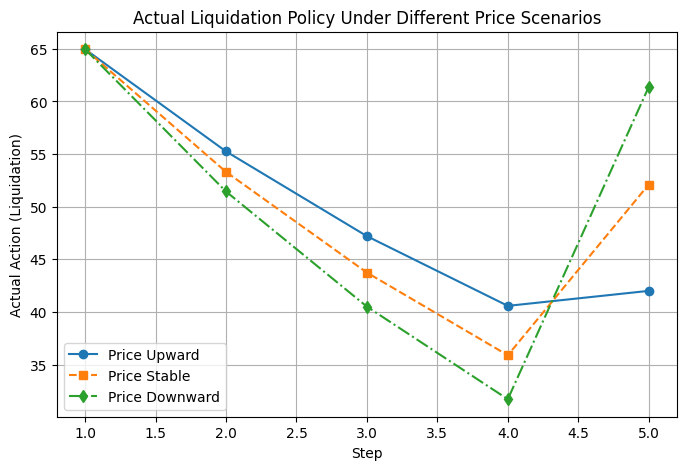

In [11]:
import matplotlib.pyplot as plt
# Load the trained model
env = LiquidationEnv(n_assets=1, initial_shares=250, vol_matrix= 0.01*np.identity(1), price_generator = PriceModel.price_model_2,lambda_value=lambda_value, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, vol_matrix= 0.01*np.identity(1),price_generator = PriceModel.price_model_2, lambda_value=lambda_value, liability=liability_value)

best_model_gbm_1 = PPO.load("../log/model/gbm_liability_10000/best_model.zip")

# Evaluate the actual actions under different price trends
avg_actual_actions_up = evaluate_policy_under_scenario(best_model_gbm_1, env_eval,5, scenario="upward")
avg_actual_actions_stable = evaluate_policy_under_scenario(best_model_gbm_1, env_eval,5, scenario="stable")
avg_actual_actions_down = evaluate_policy_under_scenario(best_model_gbm_1, env_eval, 5,scenario="downward")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1,6), avg_actual_actions_up, marker="o", linestyle="-", label="Price Upward")
plt.plot(range(1,6), avg_actual_actions_stable, marker="s", linestyle="--", label="Price Stable")
plt.plot(range(1,6), avg_actual_actions_down, marker="d", linestyle="-.", label="Price Downward")

plt.xlabel("Step")
plt.ylabel("Actual Action (Liquidation)")
plt.title("Actual Liquidation Policy Under Different Price Scenarios")
plt.legend()
plt.grid()
plt.show()

## with more liquidation periods

In [7]:
import os
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

# Hyperparameters
num_iterations = 10  # Number of iterations to update lambda
eta_lambda = 0.01  # Step size for dual variable update
delta = 0.2  # Safety threshold
lambda_value = 0.1  # Initial lambda value
liability_value = 10000  # New liability value

# Define save paths dynamically based on liability value
model_save_path = f"../log/model/longer_period_liability_{liability_value}/"
tensorboard_log_path = f"../log/tensorboard_longer_period_liability_{liability_value}/"

# Ensure directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tensorboard_log_path, exist_ok=True)

# Initialize environment with the updated liability value
env = LiquidationEnv(n_assets=1, initial_shares=250, max_steps= 10,lambda_value=lambda_value, liability=liability_value)
env_eval = LiquidationEnv(n_assets=1, initial_shares=250, max_steps= 10,lambda_value=lambda_value, liability=liability_value)

eval_callback = EvalCallback(env_eval, 
                             best_model_save_path=model_save_path,
                             eval_freq=100,
                             deterministic=True, 
                             render=False,
                             verbose=0)

# Iterate over lambda updates
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}: Training RL model with λ = {lambda_value:.4f}")

    # Train PPO with current lambda
    model = PPO("MultiInputPolicy", env, gamma=0.9999999, tensorboard_log=tensorboard_log_path, verbose=0)
    model.learn(int(8e5), progress_bar=True, callback=eval_callback)

    # Evaluate safety
    best_model = PPO.load(os.path.join(model_save_path, "best_model.zip"))
    safety_ratio, avg_reward = evaluate_policy(best_model, env_eval, num_episodes=1000)
    print(f"Safety ratio: {safety_ratio:.4f}, Avg Reward: {avg_reward:.4f}")

    # Update lambda using dual gradient update
    new_lambda = max(lambda_value - eta_lambda * (safety_ratio - (1 - delta)), 0)
    print(f"Updated λ: {new_lambda:.4f}")

    # Convergence check
    if safety_ratio > 1 - delta:
        print("Satisfying constraint; Stopping updates.")
        break
    
    lambda_value = new_lambda  # Update lambda for next iteration

    # Update environments with new lambda
    env.lambda_value = lambda_value
    env_eval.lambda_value = lambda_value


Iteration 1: Training RL model with λ = 0.1000


Output()

/home/ruijing/ruijing/liquidation_RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Safety ratio: 0.9880, Avg Reward: 0.8010
Updated λ: 0.0981
Satisfying constraint; Stopping updates.


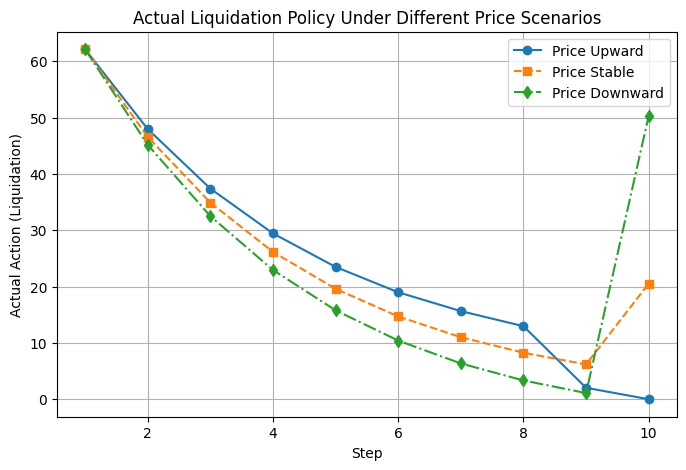

In [9]:
import matplotlib.pyplot as plt
# Load the trained model
best_model_abm_longer = PPO.load("../log/model/longer_period_liability_10000/best_model.zip")

# Evaluate the actual actions under different price trends
avg_actual_actions_up = evaluate_policy_under_scenario(best_model_abm_longer, env_eval, 10,scenario="upward")
avg_actual_actions_stable = evaluate_policy_under_scenario(best_model_abm_longer, env_eval,10, scenario="stable")
avg_actual_actions_down = evaluate_policy_under_scenario(best_model_abm_longer, env_eval, 10,scenario="downward")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1,11), avg_actual_actions_up, marker="o", linestyle="-", label="Price Upward")
plt.plot(range(1,11), avg_actual_actions_stable, marker="s", linestyle="--", label="Price Stable")
plt.plot(range(1,11), avg_actual_actions_down, marker="d", linestyle="-.", label="Price Downward")

plt.xlabel("Step")
plt.ylabel("Actual Action (Liquidation)")
plt.title("Actual Liquidation Policy Under Different Price Scenarios")
plt.legend()
plt.grid()
plt.show()